Open AI has introduced the research preview of GPT-4.5, claiming to have great "EQ(EMotional Intelligence)".

But the real question is **How do LLM remember context over long sequence to stay emotional connected?**

This suggests the importance of understanding the fundamentals of Attention Mechanism- the core of GPT Models.

In this, it includes an implementation of a **Simple Attention Mechanism** from scratch to truly understand how it works.

## Self-Attention Explained Simply: How LLMs understand Language

So starting with the crucial question

## The problem with Modeling Long Sequences

In translation task, word-by-word translation doesn't work because it requires contextual understanding and grammatical alignment between the source and target languages.

### How was this done before Transformers?

Prior to this introduction of transformer models, encoder-decoder RNNs were commonly used for machine translation tasks.

In this setup, the encoder processes a sequence of tokens from the source language, using a hidden state-a kind of intemediate layer within the neural network.

Leading to loss-of-context, especially in long complex sentence where dependencies might span long distances.

As the current hidden state is condensed representation of entire input sequence into single hidden state vector.

### What is the Self-Attention Mechanism?

Through an attention mechanism, the text-generating decoder segment of the network is capable of selecting accessing to different parts of the input tokens.

Implying that certain input tokens hold more significance (weight) than others in the generation of a specific output token, to improve LLM performance.

Self-attention in transormers- sometimes referred to as intra-attention- is a mechanism that allows the input to interact with each other ("self") in order to determine what they should focus on ("attention").

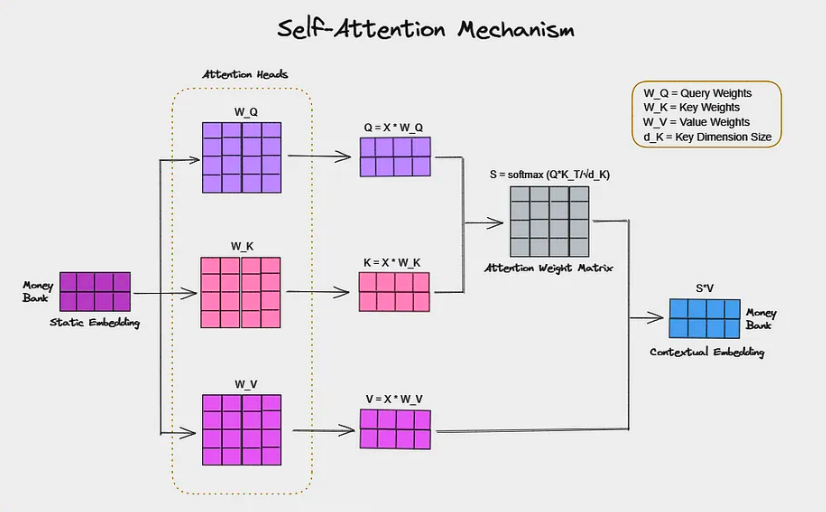

In simple words, they processed n inputs and returns n outputs. The output comprise the aggregates of these interactions and also attention scores that are calculated based on a single input.

### Implementing Simple Attention Mechanism

For illustration purpose, let's understand a simple version of self-attention, which does not contain any trainable weights.

Suppose we are given an input sequence x1 to xT.

The input is a text (for example, a sentence like "Let us understand attention mechanism") that has already been converted into [token embeddings](https://github.com/nikitaprasad21/LLM-Cheat-Code/blob/main/Input_Embeddings/Token_and_Positional_Embedding.ipynb).

For instance, x1 is a d-dimensional vector representing the word "Let", x2 for "us", so forth

**Goal:** To compute context vectors, zi for each input sequence element xi in x1 to xT, where z and x have the small dimension.

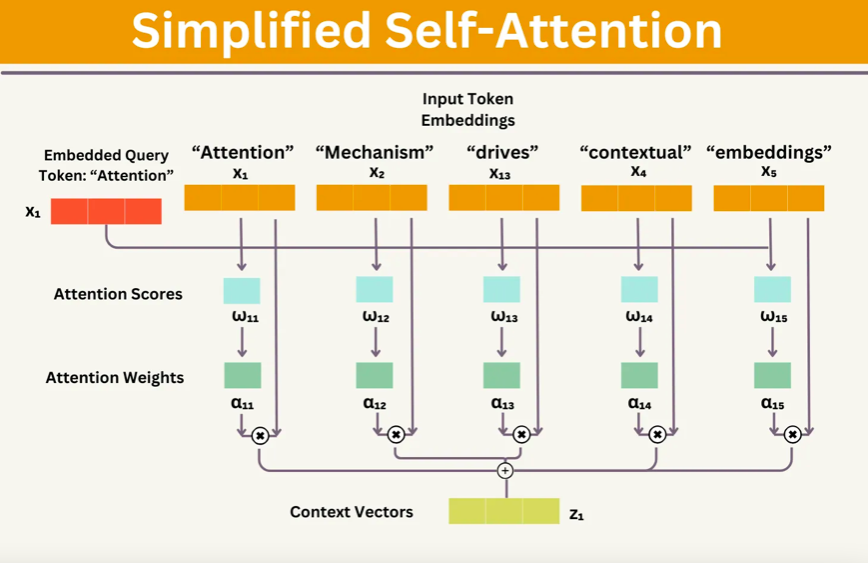

The code below walks through the figure above step by step:

In the case of the tensor shown above, each row represents a word, and each column represents an embedding dimension:

In [3]:
import torch

input_emb= torch.tensor([
    [0.12, 0.45, 0.67],  # "Attention"
    [0.34, 0.56, 0.78],  # "Mechanism"
    [0.23, 0.57, 0.91],  # "drives"
    [0.76, 0.88, 0.45],  # "Contextual"
    [0.54, 0.12, 0.34],  # "Embedding"
], dtype= torch.float32)

We use input sequence element 1, x_1 as an example to compute context vector z_1; later, we will generalize this to compute all context vectors. 

The first step is to compute the unnormalized attention scores by computing the dot product between the query x_1 and all other input tokens:

#### Step-1: Attention Scores (ω)

Raw, unnormalized values that indicates how relevant one input element is to another.

Computed by comparing the query vector (Q) of one element with the key vector (K) of all element. 

In [5]:
query= input_emb[0] #1st input token is the query

attn_scores_1= torch.empty(input_emb.shape[0])
for i, x_i in enumerate(input_emb):
    attn_scores_1[i]= torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_1)

tensor([0.6658, 0.8154, 0.8938, 0.7887, 0.3466])


**Note:** A dot product is used for multiplying two vector elements-wise and summing the resulting products:

In [6]:
result= 0.0

for idx, element in enumerate(input_emb[0]):
    result+= input_emb[0][idx] *query[idx]

print(result)
print(torch.dot(input_emb[0], query))

tensor(0.6658)
tensor(0.6658)


#### Step-2: Attention Weights (α)

They tells us the proportion of focus that the model assigns to each token relative to others.

They are the normalized version of attention score, that sum up to 1.

It represents the relative importance of one element to another in a probabilistic manner (value between 0 to 1).

Larger weights means greater relevance.

Let's normalize the unnormalized attention scores ("omegas"), so that they sum up to 1:

In [7]:
attn_weights_1_temp= attn_scores_1/ attn_scores_1.sum()

print("Attention weights:", attn_weights_1_temp)
print("Sum:", attn_weights_1_temp.sum())

Attention weights: tensor([0.1897, 0.2323, 0.2546, 0.2247, 0.0987])
Sum: tensor(1.0000)


>   **Note:** It is recommended, to use the softmax function for normalization, which is better at handling extreme values and has more desirable gradient properties during training.

let's implement a naive softmax function for scaling, which also normalizes the vector elements such that they sum up to 1:

In [8]:
def simple_softmax(x):
    return torch.exp(x)/torch.exp(x).sum(dim=0)

attn_weights_1_naive= simple_softmax(attn_scores_1)
print("Attention weights:", attn_weights_1_naive)
print("Sum:", attn_weights_1_naive.sum())

Attention weights: tensor([0.1896, 0.2202, 0.2381, 0.2144, 0.1378])
Sum: tensor(1.)


However, the naive implementation above can suffer from numerical instability issues for large or small input values due to overflow and underflow issues.

Hence, in practise, it's recommended to use the PyTorch implementation of softmax instead, which has been highly optimized for performance:

In [9]:
attn_weights_1= torch.softmax(attn_scores_1, dim=0)

print("Attention weights:", attn_weights_1)
print("Sum:", attn_weights_1.sum())

Attention weights: tensor([0.1896, 0.2202, 0.2381, 0.2144, 0.1378])
Sum: tensor(1.0000)


#### Step-3: Context Vectors (Z)

The input embedding vectors are converted to the context vector.

It aims to capture both sematic and syntactic information from the input embeddings.

It is the key combination that encodes the weighted representation of the input sequence, to capture most relevant information for each element in the sequence by considering its relationshop with all other tokens.

Context size is the maximum number of previous tokens the LLM looks at before predicting next token.

Compute the context vector z_1 by multiplying the embedded input tokens, x_i with the attention weights and sum the resulting vectors: 

In [13]:
query= input_emb[0] # 1st input token is the query

context_vec_1= torch.zeros(query.shape)
for i, x_i in enumerate(input_emb):
    context_vec_1 += attn_weights_1[i]*x_i

print(context_vec_1)

tensor([0.3897, 0.5495, 0.6587])


### Computing Attention Weights for All input Tokens

Above, we computed the attention weights and context for input 1.

Next, we are generalizing this computation to compute all attention weights and context vectors.

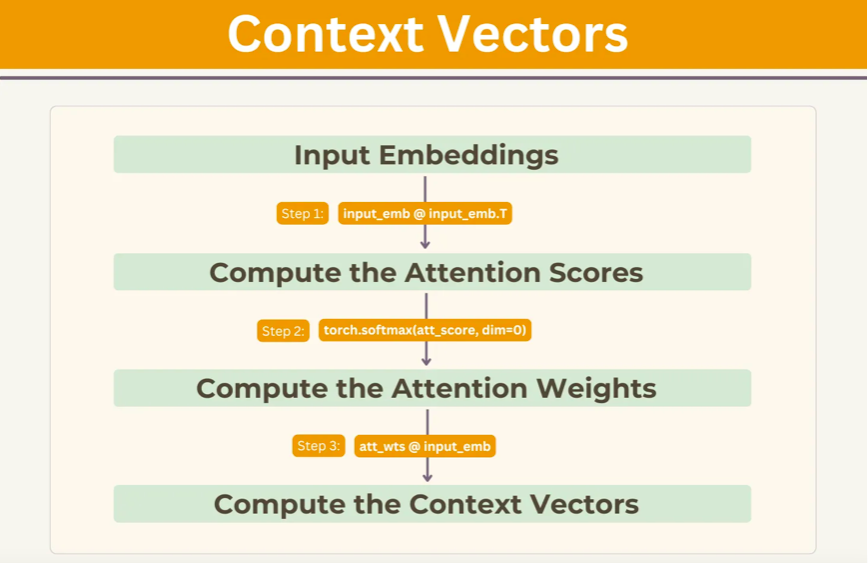

Applying **Step 1** to all pairwise elements to compute the unnormalized attention score matrix:

In [14]:
attn_scores= torch.empty(5,3)

In [15]:
#Compute score for all pairs
attn_scores= input_emb @ input_emb.T
print(attn_scores)

tensor([[0.6658, 0.8154, 0.8938, 0.7887, 0.3466],
        [0.8154, 1.0376, 1.1072, 1.1022, 0.5160],
        [0.8938, 1.1072, 1.2059, 1.0859, 0.5020],
        [0.7887, 1.1022, 1.0859, 1.5545, 0.6690],
        [0.3466, 0.5160, 0.5020, 0.6690, 0.4216]])


Similarly to **Step 2** previously, we normalize each row so that the values in each row sum to 1:

In [16]:
# Normalize Attention Scores
attn_weights=torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.1896, 0.2202, 0.2381, 0.2144, 0.1378],
        [0.1766, 0.2206, 0.2365, 0.2353, 0.1309],
        [0.1821, 0.2254, 0.2488, 0.2207, 0.1231],
        [0.1481, 0.2026, 0.1994, 0.3185, 0.1314],
        [0.1721, 0.2039, 0.2010, 0.2376, 0.1855]])


Lastly, applying **Step 3** to compute all context vectors:

In [17]:
# Compute all context vectors
all_context_vecs= attn_weights @input_emb
print(all_context_vecs)

tensor([[0.3897, 0.5495, 0.6587],
        [0.4001, 0.5606, 0.6560],
        [0.3899, 0.5589, 0.6653],
        [0.4455, 0.5898, 0.6267],
        [0.4169, 0.5375, 0.6272]])


As a sanity check, the previously computed context vector z_1 can be found in the 1st row in above:

In [18]:
print("Previous 1st context vector:", context_vec_1)

Previous 1st context vector: tensor([0.3897, 0.5495, 0.6587])


Now, each token has a dynamically computed representation based on its relationship with all other token.